# Customer Churn Prediction Using Decision Tree

# 1. Import Dependencies

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn import tree

# Import ONNX
import skl2onnx
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
import onnxruntime as ort
import numpy as np
import time

warnings.filterwarnings('ignore')

# 2. Feature Engineering

In [2]:
# Loading the dataset
df = pd.read_csv('dataset.csv')

In [3]:
df.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2,134603.88,1,1,1,71725.73,0


In [4]:
# Adding new features to enrich the dataset
df['BalancePerProduct'] = df['Balance'] / (df['NumOfProducts'] + 1)  # avoid division by zero

# Features and target
x = df[['Age','NumOfProducts','Balance','BalancePerProduct']]
y = df[['Exited']]

# 3. Model Building using Scikit-learn

In [5]:
# Train-Test Split: 70% training and 30% testing
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

# Training the Decision Tree model
clf = DecisionTreeClassifier(max_depth=5, random_state=42)
clf.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,5
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


# 4. Saving the Model: Scikit-learn and ONNX Formats

In [6]:
# Scikit-learn
import pickle

with open("decision_tree.pkl", "wb") as f:   # Save the model
    pickle.dump(clf, f)

# # Load the model later
# with open("decision_tree.pkl", "rb") as f:
#     clf_loaded = pickle.load(f)

In [7]:
# ONNX
initial_type = [('input', FloatTensorType([None, 4]))] # Define input type (batch size 1, 4 features)

# Convert model
onnx_model = convert_sklearn(clf, initial_types=initial_type)

# Save to disk
onnx_model_path = "decision_tree.onnx"
with open(onnx_model_path, "wb") as f:
    f.write(onnx_model.SerializeToString())

# 5. Prediction & Evaluation

In [8]:
# Accuracy is the proportion of correct predictions among the total number of cases processed
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Model Accuracy: {accuracy}')
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Model Accuracy: 0.848

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.94      0.91      2416
           1       0.65      0.48      0.55       584

    accuracy                           0.85      3000
   macro avg       0.77      0.71      0.73      3000
weighted avg       0.84      0.85      0.84      3000



# 6. Comparing Inference Speed Between Scikit-learn (Pickle) and ONNX Formats

In [9]:
time_sum = 0
n_iters = 500

for i in range(n_iters):
    sklearn_input = np.random.rand(1, 4).astype(np.float32)   # Random input with shape (1, 4)

    t0 = time.time()
    clf.predict(sklearn_input)
    time_sum += (time.time() - t0)

print(f"Average inference time over {n_iters} iterations (sklearn): {time_sum / n_iters:.6f} seconds")

Average inference time over 500 iterations (sklearn): 0.000060 seconds


In [10]:
# Using ONNX
# Initialize inference session
ort_session = ort.InferenceSession(onnx_model_path)

time_sum = 0
n_iters = 500

for i in range(n_iters):
    onnx_input = np.random.rand(1, 4).astype(np.float32)   # Random input with shape (1, 4)
    
    t0 = time.time()
    ort_session.run(None, {"input": onnx_input})
    time_sum += (time.time() - t0)

print(f"Average inference time over {n_iters} iterations (ONNX): {time_sum / n_iters:.6f} seconds")

Average inference time over 500 iterations (ONNX): 0.000010 seconds


# 6. Visualizing the Decision Tree

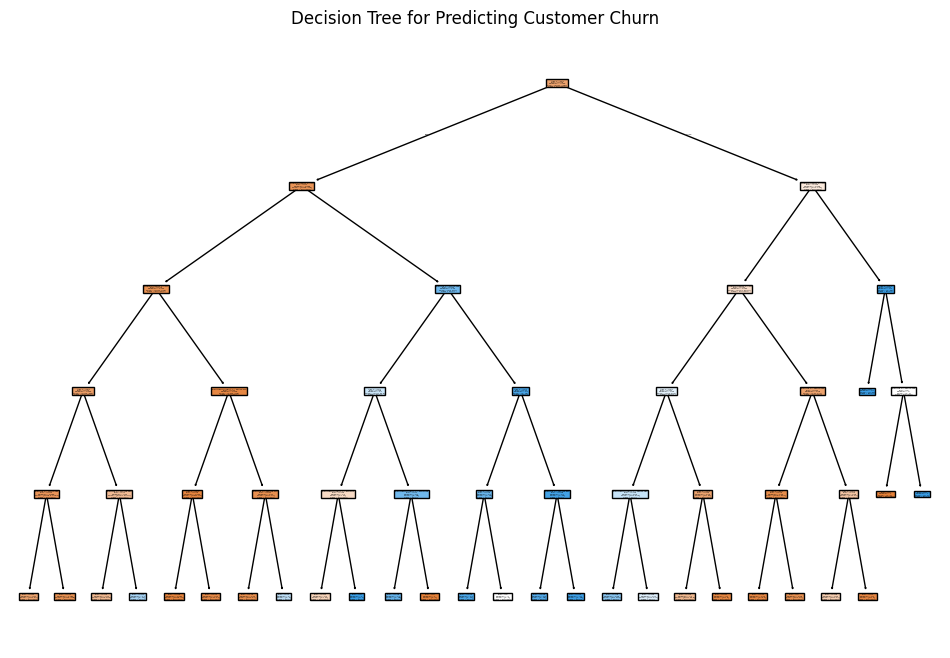

In [11]:
plt.figure(figsize=(12,8))
tree.plot_tree(clf, filled=True, feature_names=['Age', 'NumOfProducts', 'Balance','BalancePerProduct'], class_names=['No Churn', 'Churn'])
plt.title('Decision Tree for Predicting Customer Churn')
plt.show()